In [1]:
import os
import sys
import requests
from dotenv import load_dotenv
from typing import Dict, Any

# Add current directory to path for imports
sys.path.insert(0, os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd())

print(sys.path)
print(os.getcwd())

load_dotenv("/Users/paddy/Documents/Github/Dump-Truck/last-fm-spotify-agent/.env")


['/Users/paddy/Documents/Github/Dump-Truck/last-fm-spotify-agent', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python312.zip', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12', '/Users/paddy/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/lib-dynload', '', '/Users/paddy/Documents/Github/Dump-Truck/.venv/lib/python3.12/site-packages']
/Users/paddy/Documents/Github/Dump-Truck/last-fm-spotify-agent


True

In [2]:
import os
from opentelemetry import trace as trace_api
from opentelemetry.sdk.trace.export import BatchSpanProcessor

from phoenix.otel import HTTPSpanExporter
from arize.otel import register as arize_register
from openinference.instrumentation.langchain import LangChainInstrumentor

PHOENIX_COLLECTOR = "https://app.phoenix.arize.com/s/padmanabhan-rajendra/v1/traces"
PHOENIX_API_KEY = os.environ.get("PHOENIX_API_KEY")

# 1) Arize tracer provider + its default exporter
tracer_provider = arize_register(
    space_id=os.environ["ARIZE_SPACE_ID"],
    api_key=os.environ["ARIZE_API_KEY"],
    project_name="lastfm-spotify-app",
)

# 2) Add Phoenix exporter as an additional span processor
phoenix_exporter = HTTPSpanExporter(
    endpoint=PHOENIX_COLLECTOR,
    headers={"authorization": f"Bearer {PHOENIX_API_KEY}"},
)
phoenix_processor = BatchSpanProcessor(phoenix_exporter)

# Add the Phoenix processor to the existing tracer provider
tracer_provider.add_span_processor(phoenix_processor)

# If you ALSO want a local Phoenix target, you can add it:
local_exporter = HTTPSpanExporter(endpoint="http://127.0.0.1:6006/v1/traces")
local_processor = BatchSpanProcessor(local_exporter)
tracer_provider.add_span_processor(local_processor)

# 3) Set global + instrument LangChain
trace_api.set_tracer_provider(tracer_provider)
LangChainInstrumentor().instrument(tracer_provider=tracer_provider)

print("LangChain instrumented → Arize + Phoenix (SaaS [+ local if enabled])")


Overriding of current TracerProvider is not allowed


🔭 OpenTelemetry Tracing Details 🔭
|  Arize Project: lastfm-spotify-app
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: otlp.arize.com
|  Transport: gRPC
|  Transport Headers: {'authorization': '****', 'api_key': '****', 'arize-space-id': '****', 'space_id': '****', 'arize-interface': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

LangChain instrumented → Arize + Phoenix (SaaS [+ local if enabled])


In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# from langchain_google_genai import ChatGoogleGenerativeAI
# llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

# from langchain_groq import ChatGroq
# llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

from langchain_deepseek import ChatDeepSeek
llm = ChatDeepSeek(
    model="deepseek/deepseek-v3.2",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    api_base="https://openrouter.ai/api/v1",
    extra_body={"reasoning": {"enabled": True}},
)

In [ ]:
from lastfm_spotify_tools import (  # type: ignore
    get_artist_albums,
    get_artist_details,
    get_artist_details_by_name,
    get_artist_info,
    get_artist_top_tracks,
    get_lastfm_user_info,
    get_lastfm_user_top_artists,
    get_track_info,
    search_artist_by_name,
    search_artists_by_genre,
)

tools = [
    get_lastfm_user_info,
    get_lastfm_user_top_artists,
    get_artist_info,
    get_track_info,
    search_artists_by_genre,
    search_artist_by_name,
    get_artist_details,
    get_artist_details_by_name,
    get_artist_top_tracks,
    get_artist_albums,
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=True)

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [ ]:
LASTFM_SPOTIFY_SYSTEM_PROMPT = """
You are a music assistant who helps users with queries about artists, 
tracks, albums, and music listening habits using Last.fm and Spotify data.

You have access to these tools:

Last.fm tools:
- get_lastfm_user_info: Get user profile information
- get_lastfm_user_top_artists: Get a user's top artists with playcount and time period filters (7day, 1month, 3month, 6month, 12month, overall)
- get_artist_info: Get artist metadata from Last.fm
- get_track_info: Get track metadata from Last.fm

Spotify tools:
- search_artists_by_genre: Search for artists by genre
- search_artist_by_name: Search for artists by name (returns list of matches)
- get_artist_details: Get detailed artist information by Spotify ID (includes followers, popularity, genres)
- get_artist_details_by_name: Get detailed artist information by name (convenience function that searches and returns top match)
- get_artist_top_tracks: Get an artist's top tracks for a specific market
- get_artist_albums: Get an artist's albums and releases

Guidelines:
- Choose the appropriate tool based on the user's query
- Use Last.fm for listening history, scrobble data, and user-specific top artists
- Use Spotify for genre searches, artist discovery, detailed track/album info, and artist statistics (followers, popularity)
- When users ask about artist stats by name, use get_artist_details_by_name for convenience
- Provide clear, helpful responses based on the tool results
"""

sys_msg = SystemMessage(content=LASTFM_SPOTIFY_SYSTEM_PROMPT)


In [8]:
def music_assistant(state: MessagesState):
    return {
        "messages": [
            llm_with_tools.invoke([sys_msg] + state["messages"])
        ]
    }


In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

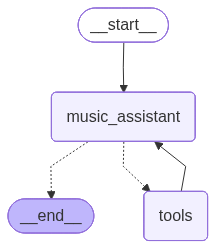

In [10]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("music_assistant", music_assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "music_assistant")

builder.add_conditional_edges(
    "music_assistant",
    tools_condition,
)

builder.add_edge("tools", "music_assistant")

music_graph = builder.compile(checkpointer=memory)
display(Image(music_graph.get_graph(xray=True).draw_mermaid_png()))


In [11]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="Search for synthwave artists on Spotify")]
messages = music_graph.invoke({"messages": messages}, config)


In [12]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Search for synthwave artists on Spotify
================================== Ai Message ==================================
Tool Calls:
  search_artists_by_genre (chatcmpl-tool-24190f206a964236ad40513646076ffe)
 Call ID: chatcmpl-tool-24190f206a964236ad40513646076ffe
  Args:
    genre: synthwave
    limit: 20
================================= Tool Message =================================
Name: search_artists_by_genre

{"artists": {"href": "https://api.spotify.com/v1/search?offset=0&limit=20&query=genre%3A%22synthwave%22&type=artist", "limit": 20, "next": null, "offset": 0, "previous": null, "total": 0, "items": []}}
================================== Ai Message ==================================
Tool Calls:
  search_artists_by_genre (019b03bb33630d22bca0c8695e73ff30)
 Call ID: 019b03bb33630d22bca0c8695e73ff30
  Args:
    genre: synth-pop
    limit: 20
================================= Tool Message =========

In [13]:
messages = [HumanMessage(content="Can you get that artist's total play count from last fm ?")]
messages = music_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Search for synthwave artists on Spotify
================================== Ai Message ==================================
Tool Calls:
  search_artists_by_genre (chatcmpl-tool-24190f206a964236ad40513646076ffe)
 Call ID: chatcmpl-tool-24190f206a964236ad40513646076ffe
  Args:
    genre: synthwave
    limit: 20
================================= Tool Message =================================
Name: search_artists_by_genre

{"artists": {"href": "https://api.spotify.com/v1/search?offset=0&limit=20&query=genre%3A%22synthwave%22&type=artist", "limit": 20, "next": null, "offset": 0, "previous": null, "total": 0, "items": []}}
================================== Ai Message ==================================
Tool Calls:
  search_artists_by_genre (019b03bb33630d22bca0c8695e73ff30)
 Call ID: 019b03bb33630d22bca0c8695e73ff30
  Args:
    genre: synth-pop
    limit: 20
================================= Tool Message =========